In [1]:
import matplotlib.pyplot as plt
import os, re
import scipy.io
from collections import defaultdict
import numpy as np
import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Whole-Image Human Attention Maps

In [2]:
human_attention_path = {
    'vehicle':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/results/explanation/231018_vehicle_whole_screen_vb_fixed_pos/human_saliency_map',
    'human':'/mnt/h/OneDrive - The University Of Hong Kong/bdd/results/explanation/231018_human_whole_screen_vb_fixed_pos/human_saliency_map',
}

human_attention = defaultdict(defaultdict)

for category, path in human_attention_path.items():
    for file in os.listdir(path):
        img_idx = re.findall(r'\d+_',file)[-1].replace('_','')
        mat = scipy.io.loadmat(os.path.join(path,file))
        human_attention[category][img_idx] = mat['output_map_norm']

In [3]:
xai_saliency_path = {
    'vehicle': '/mnt/h/Projects/HKU_XAI_Project/Yolov5self_GradCAM_Pytorch_1/multi_layer_analysis/odam_test_results',
    'human' : '/mnt/h/jinhan/xai/yolov5BDD/multi_layer_analysis/odam_test_results',
}

xai_saliency_maps = {
    "vehicle":defaultdict(defaultdict),
    "human":defaultdict(defaultdict)
}
PCC_all = {
    "vehicle":defaultdict(defaultdict),
    "human":defaultdict(defaultdict)
}
RMSE_all = {
    "vehicle":defaultdict(defaultdict),
    "human":defaultdict(defaultdict)
}

for category, path in xai_saliency_path.items():
    for dir in os.listdir(path):
        layer_num = int(re.findall(r"F\d+",dir)[-1].replace('F',''))

        for file in os.listdir(os.path.join(path,dir)):
            if '.mat' not in file: continue
            img_idx = re.findall(r'\d+-',file)[-1].replace('-','')
            mat = scipy.io.loadmat(os.path.join(path,dir,file))
            xai_saliency_maps[category][layer_num][img_idx] = mat['masks_ndarray']

            PCC_all[category][layer_num][img_idx] = np.corrcoef(xai_saliency_maps[category][layer_num][img_idx].flatten(), human_attention[category][img_idx].flatten())[0,1]
            RMSE_all[category][layer_num][img_idx] = RMSE(xai_saliency_maps[category][layer_num][img_idx].flatten(), human_attention[category][img_idx].flatten())

In [10]:
PCC_layer_mean_veh = pd.DataFrame.from_dict(PCC_all['vehicle']).mean(axis=0)
RMSE_layer_mean_veh = pd.DataFrame.from_dict(RMSE_all['vehicle']).mean(axis=0)

PCC_layer_mean_hum = pd.DataFrame.from_dict(PCC_all['human']).mean(axis=0)
RMSE_layer_mean_hum = pd.DataFrame.from_dict(RMSE_all['human']).mean(axis=0)

PCC_layer_mean_all = pd.concat([pd.DataFrame.from_dict(PCC_all['vehicle']),pd.DataFrame.from_dict(PCC_all['human'])],ignore_index=True).mean(axis=0)
RMSE_layer_mean_all = pd.concat([pd.DataFrame.from_dict(RMSE_all['vehicle']),pd.DataFrame.from_dict(RMSE_all['human'])],ignore_index=True).mean(axis=0)

In [11]:
PCC_veh_sorted = PCC_layer_mean_veh.sort_index()
RMSE_veh_sorted = RMSE_layer_mean_veh.sort_index()

PCC_hum_sorted = PCC_layer_mean_hum.sort_index()
RMSE_hum_sorted = RMSE_layer_mean_hum.sort_index()

PCC_all_sorted = PCC_layer_mean_all.sort_index()
RMSE_all_sorted = RMSE_layer_mean_all.sort_index()

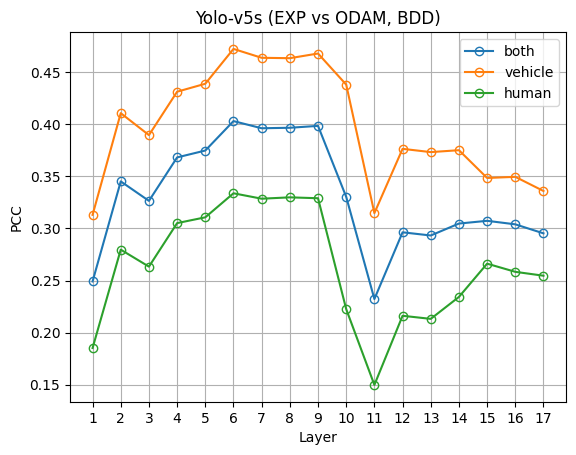

In [20]:
plt.figure()
plt.plot(PCC_all_sorted.index, PCC_all_sorted.values, marker='o',fillstyle='none',label="both")
plt.plot(PCC_veh_sorted.index, PCC_veh_sorted.values, marker='o',fillstyle='none',label="vehicle")
plt.plot(PCC_hum_sorted.index, PCC_hum_sorted.values, marker='o',fillstyle='none',label="human")
plt.xticks(PCC_all_sorted.index)
# plt.ylim((0.2,0.8))
plt.grid()
plt.legend()
plt.xlabel('Layer')
plt.ylabel('PCC')
plt.title("Yolo-v5s (EXP vs ODAM, BDD)")
plt.show()

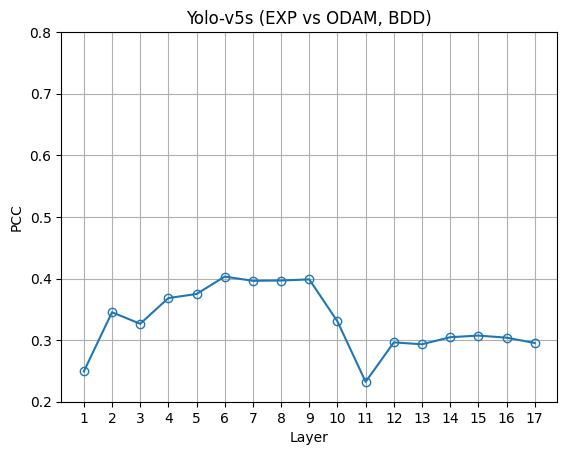

In [21]:
plt.figure()
plt.plot(PCC_all_sorted.index, PCC_all_sorted.values, marker='o',fillstyle='none',label="both")
plt.xticks(PCC_all_sorted.index)
plt.ylim((0.2,0.8))
plt.grid()
# plt.legend()
plt.xlabel('Layer')
plt.ylabel('PCC')
plt.title("Yolo-v5s (EXP vs ODAM, BDD)")
plt.show()

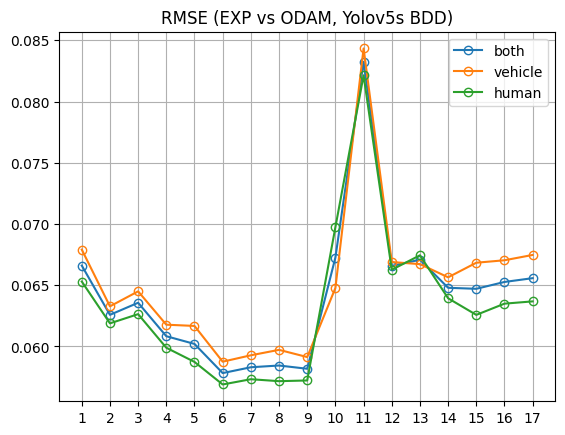

In [14]:
plt.figure()
plt.plot(RMSE_all_sorted.index, RMSE_all_sorted.values, marker='o',fillstyle='none',label="both")
plt.plot(RMSE_veh_sorted.index, RMSE_veh_sorted.values, marker='o',fillstyle='none',label="vehicle")
plt.plot(RMSE_hum_sorted.index, RMSE_hum_sorted.values, marker='o',fillstyle='none',label="human")
plt.xticks(RMSE_all_sorted.index)
# plt.ylim((0,0.3))
plt.grid()
plt.legend()
plt.title("RMSE (EXP vs ODAM, Yolov5s BDD)")
plt.show()

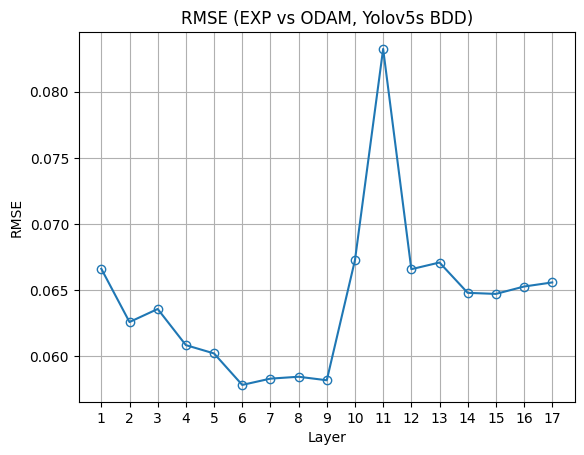

In [17]:
plt.figure()
plt.plot(RMSE_all_sorted.index, RMSE_all_sorted.values, marker='o',fillstyle='none',label="both")
plt.xticks(RMSE_all_sorted.index)
plt.ylim((0,0.3))
plt.grid()
plt.title("Yolo-v5s (EXP vs ODAM, BDD)")
plt.xlabel('Layer')
plt.ylabel('RMSE')
plt.show()